In [7]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from string import ascii_uppercase
from numpy import random
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
db = np.loadtxt('../Frogs_MFCCs.data', delimiter = ',')
#Bufonidae - Rhinella - Rhinellagranulosa
#Dendrobatidae - Ameerega - Ameeregatrivittata
#Hylidae - 1.Dendropsophus, 2.Hypsiboas, 3.Osteocephalus, 4.Scinax - 1.HylaMinuta, 2.HypsiboasCinerascens, 2.HypsiboasCordobae, 3.OsteocephalusOophagus, 4.ScinaxRuber
#Leptodactylidae - 1.Adenomera, 2.Leptodactylus - 1.AdenomeraAndre, 1.AdenomeraHylaedactylus, 2.LeptodactylusFuscus

#Muestras
X = db[:, 0:22]

#Familias
Y = db[:, 22:25]

#Grupos
G = db[:, 25]

In [3]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

## KNN (Cross-Validation)

The best model was Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('KNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1, p=2,
                                      weights='uniform'))],
         verbose=False) 

Sensibilidad: 0.9710118891170557 - Intervalo Sensibilidad: 0.04448707027726462 
Eficiencia: 0.9883268482490273 - Intervalo Eficiencia: 0.0020798540226647736 
Precision: 0.97085077788942 - Intervalo Precision: 0.04483989974391295 
F-Score: 0.9698927143638094 - Intervalo F-Score: 0.034069135167107294 
Error_Prueba: 0.011673151750972763 - Intervalo Error: 0.002079854022664781 
Tiempo ejecución: 285.2496314048767


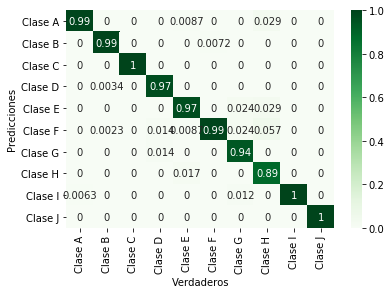

In [5]:
def KNN_model_CV(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])   
    KNN = KNeighborsClassifier()
    pca = PCA()
    pipeline = Pipeline(steps=[('pca', pca), ('KNN', KNN)])
    param_grid = {
    'pca__n_components': [1, 2, 3, 4, 5, 15, 20, 25, 40],
    'KNN__n_neighbors': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)
    }
    clf = GridSearchCV(pipeline, param_grid, cv=5)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelKNN, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = KNN_model_CV(graficar = True)
print('The best model was', modelKNN,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## Random Forest (Cross-Validation)

In [8]:
def RF_model_CV(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    RF = RandomForestClassifier()
    pca = PCA()
    pipeline = Pipeline(steps=[('pca', pca), ('RF', RF)])
    param_grid = {
    'pca__n_components': [1, 2, 3, 4, 5, 15, 20, 25, 40],
    'RF__n_estimators': (5, 10, 20, 50, 100),
    'RF__max_features': (2, 5, 10, 13, 15, 19, 22)
    }
    clf = GridSearchCV(pipeline, param_grid, cv=5)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRF, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RF_model_CV(graficar = True)
print('The best model was', modelRF,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

KeyboardInterrupt: 

## Maquinas de Soporte Vectorial con kernel lineal y con kernel RBF (Cross-Validation)

In [9]:
def SVC_model_CV(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    SupportVC = SVC(decision_function_shape='ovo' , probability = True)
    pca = PCA()
    pipeline = Pipeline(steps=[('pca', pca), ('SupportVC', SupportVC)])
    param_grid = {
    'pca__n_components': [1, 2, 3, 4, 5, 15, 20, 25, 40],
    'SupportVC__kernel': ('linear', 'rbf'),
    'SupportVC__C': (0.001, 0.01, 0.1, 1, 10, 100, 200, 300),
    'SupportVC__gamma': (0.001, 0.01, 0.1, 1)
    }
    clf = GridSearchCV(pipeline, param_grid, cv=5)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelSVM, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = SVC_model_CV(graficar = True)
print('The best model was', modelSVM,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

KeyboardInterrupt: 